# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [1]:
import numpy as np 

H = np.load('Hamiltonian_Example.npy')

In [2]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-3.34084762e+00+0.00000000e+00j, -3.29295138e+00+0.00000000e+00j,
       -2.86387634e+00+0.00000000e+00j, -2.78526086e+00+0.00000000e+00j,
       -1.56155281e+00+0.00000000e+00j, -1.56155281e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -5.61552813e-01+0.00000000e+00j, -5.61552813e-01+0.00000000e+00j,
        7.31507328e-16+0.00000000e+00j,  5.07690516e-01+0.00000000e+00j,
        5.23028722e-01+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00-1.27192026e-16j,
        1.00000000e+00+1.27192026e-16j,  1.47697128e+00+0.00000000e+00j,
        1.49230948e+00+0.00000000e+00j,  2.00000000e+00+0.00000000e+00j,
        2.56155281e+00+0.00000000e+00j,  2.56155281e+00+0.00000000e+00j,
        3.00000000e+00+0.00000000e+00j,  3.00000000

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [38]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [4]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [5]:
import pandas as pd

pd.DataFrame(blocks['3,4'].to_matrix())

,0,1,2,3,4,5,6,7
0,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j


In [6]:
print(blocks['0,0'])

SummedOp([
  3.25 * III,
  -0.5 * IIX,
  0.25 * IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -2.25 * IZI,
  -0.5 * IZX,
  0.25 * IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -2.0 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [7]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size**2)] for j in range(size**2)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]

<ipython-input-7-ce06f5abc6d5>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-7-ce06f5abc6d5>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [8]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

-3.3408476172483366
(-3.340847617248337+0j)


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [9]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [19]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i


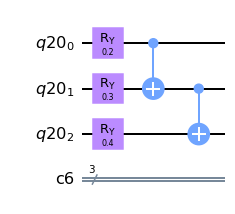

In [20]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [21]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir


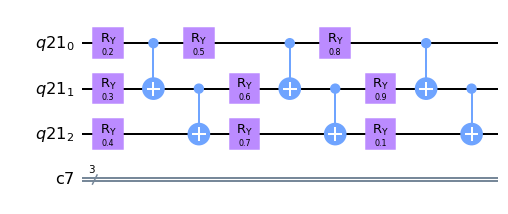

In [22]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

In order to deal with off diagonal blocks, we will also need to form $$ U^{ab} = I\otimes U^a + X \otimes U^b$$

In order to great this gate we need a controled-Ry gate.  The controled-Ry can be built as $C_{R_y}(\phi) = R_y(\phi/2)C_{NOT}R_y(-\phi/2)C_{NOT}$

In [131]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

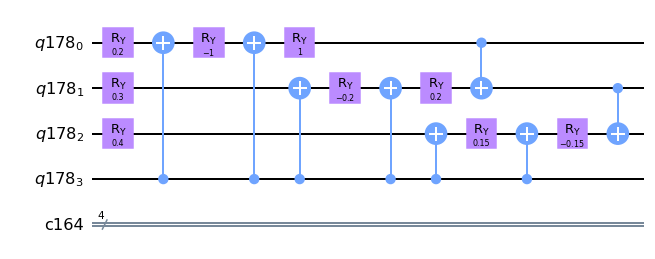

In [132]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

Let's check to make sure we are generating the right thing

In [134]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [135]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

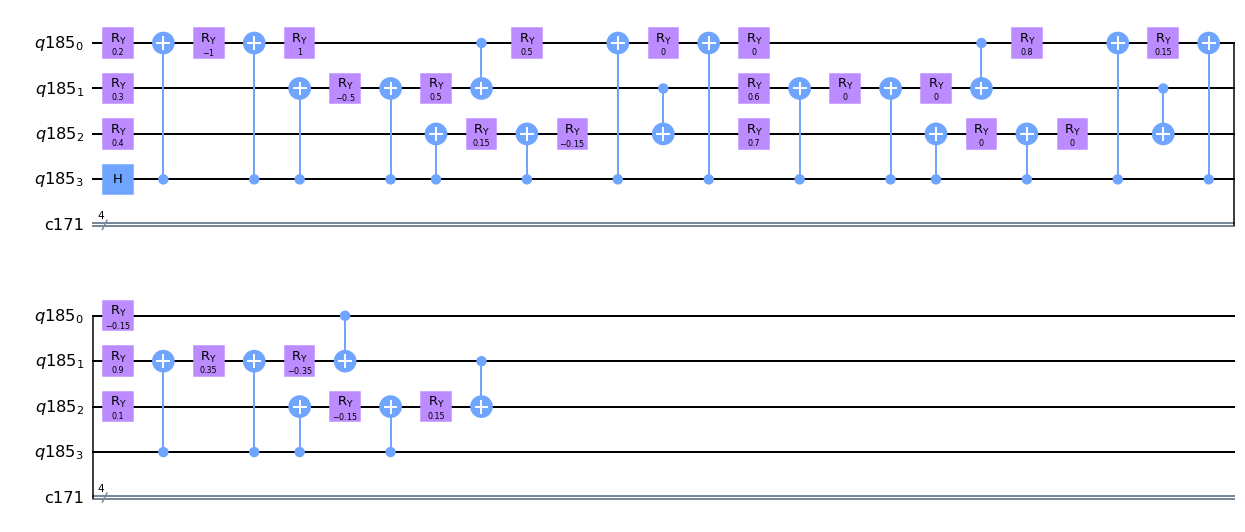

In [136]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  The we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

### !!! Issue: We only get counts from the quantum computer.  If $<\psi^a|P_{ab,p}|\psi^b> ~< 0$  we will not know !!!

To fix the issue we need to go through the circuit and add a Hadamard gate on each qubit with an X (ect...) then take $(-1)^n$ where n is the number of up qubits with a Puali. 

for example:
$$<\psi|XZ|\psi> = <(R^{\dagger}_y(\pi/2)\otimes I)\psi|R_y(\pi/2)XR^{\dagger}_y(\pi/2)\otimes Z|(R_y(\pi/2)\otimes I)\psi>$$
$$ = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R_y(\pi/2)\otimes I)\psi>$$
$$ = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R_y(\pi/2) \psi>|^2 + (-1)^1|<01|R_y(\pi/2) \psi>|^2 + (-1)^2|<11|R_y(\pi/2) \psi>|^2$$

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [137]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(qr,cr)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][17].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(0.7209464513295367+0j)
0.7209464513295368
0.71484375
Moon_Cheese is not a recognized method


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
In order to great this gate we need a controled-Ry gate.  We see below that the controled-Ry can be built as $C_{R_y}(\phi) = R_y(\phi/2)C_{NOT}R_y(-\phi/2)C_{NOT}$

In [176]:
#Run a test
p_label = blocks['0,0'][18].primitive.to_label()

#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,[[1.2,2.3,3.4]])

#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,[[2.5,0.7,1.8]])


#combined 
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
psi0 = U_off(cir,[[1.2,2.3,3.4]],[[2.5,0.7,1.8]])


wave_a = qi.Statevector.from_instruction(psi_a).data
wave_b = qi.Statevector.from_instruction(psi_b).data
puali = qi.Operator.from_label(p_label).data

print(p_label)
print('Test:', np.dot(np.conjugate(wave_b),np.dot(puali,wave_a)))
print('Simple:', measure_pauli('X' + p_label,psi0,method = 'simple') )
print('Matrix:', measure_pauli('X' + p_label,psi0,method = 'matrix') )
print('Simulator', measure_pauli('X' + p_label,psi0,method = 'simulator') )
print( measure_pauli('X' + p_label,psi0,method = 'Moon_Cheese') )

YYX
Test: (0.5738814342502425+0j)
Simple: (0.5738814342502424+0j)
Matrix: 0.5738814342502425
Simulator 0.59375
Moon_Cheese is not a recognized method


In [109]:
from qiskit import quantum_info as qi

II = qi.Operator.from_label('II')
IX = qi.Operator.from_label('IX')
ZI = qi.Operator.from_label('ZI')
ZX = qi.Operator.from_label('ZX')
IZ = qi.Operator.from_label('IZ')
IY = qi.Operator.from_label('IY')

Cnot = 1/2*(II + IX + ZI - ZX).data
CRiz = (np.cos(0.33)*II + 1j*np.sin(0.33)*IZ).data
Riz = (np.cos(0.33)*II - 1j*np.sin(0.33)*IZ).data
CRiy = (np.cos(0.33)*II + 1j*np.sin(0.33)*IY).data
Riy = (np.cos(0.33)*II - 1j*np.sin(0.33)*IY).data

print(np.dot(Riy,Riy))
pd.DataFrame(np.dot(np.dot(Riy,np.dot(Cnot,CRiy)),Cnot))

[[ 0.78999223+0.j -0.61311685+0.j  0.        +0.j  0.        +0.j]
 [ 0.61311685+0.j  0.78999223+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.78999223+0.j -0.61311685+0.j]
 [ 0.        +0.j  0.        +0.j  0.61311685+0.j  0.78999223+0.j]]


,0,1,2,3
0,1.000000e+00+0.000000e+00j,2.437775e-17+0.000000e+00j,0.000000+0.000000j,0.000000+0.000000j
1,2.437775e-17+0.000000e+00j,1.000000e+00+0.000000e+00j,0.000000+0.000000j,0.000000+0.000000j
2,0.000000e+00+0.000000e+00j,0.000000e+00+0.000000e+00j,0.789992+0.000000j,-0.613117+0.000000j
3,0.000000e+00+0.000000e+00j,0.000000e+00+0.000000e+00j,0.613117+0.000000j,0.789992+0.000000j


This should be everything I need to make this work but I need to write it all down in a coincise way before I attempt to code it.

For now we will ignore this issue.

### !!! End of issue disscusion !!!

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [18]:
#number of blocks
T = 1

phi = []
for b in range(bL):
    phi_b = []
    for t in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index

Now let us define a list of circuits whose projection onto $|000\ldots>$ are summed to get the value of $E$.  I will only do the upper blocks meaning that the wieght of the off diagonal blocks is doubled.

In [19]:
def E_Circs(phi,blocks):
    cir_l = []
    for key in list(blocks.keys()):
        for p in blocks[key]:
            qr = QuantumRegister(Q)
            cr = ClassicalRegister(Q)
            cir = QuantumCircuit(qr , cr)
            a = int(key.split(',')[0])
            b = int(key.split(',')[1])
            w = p.coeff
            if a != b:
                w = 2*p.coeff
            
            cir = U(cir,phi[b])
            p_cir = p.to_circuit()
            cir = cir.compose(p_cir)
            cir = U_dagger(cir,phi[a])
            cir.measure(qr, cr)
            
            cir_l.append([w,cir])
    
    return cir_l
            
        
        

-0.5


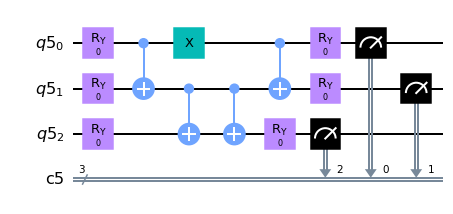

In [20]:
e_circs = E_Circs(phi,blocks)
p = 1
print(e_circs[p][0])
e_circs[p][1].draw(output = 'mpl')

## Simulate finding E

Before we move on to the optimization method, let's see how we can use *E_Circs* to find the value of E.  To do this I will use the qasm simulator from Aer.

In [21]:
from qiskit import Aer
from qiskit.visualization import *

In [22]:
#get the simulator
sim = Aer.get_backend("qasm_simulator")

To get a value for E, we execute each circuit, find the projection of the final circuit onto $|000\ldots>$, and multiply the result by the wieght of the circuit.

In [23]:
def find_E(e_circs):
    E = 0
    for p_circ in e_circs:
        circ = p_circ[1]
        w = p_circ[0]
        r = execute(circ, backend = sim).result().get_counts()
        r_keys = list(r.keys())
        total = 0
        for key in r_keys:
            total += r[key]
        if '000' in r:
            num = r['000']/total
        else:
            num = 0
        E += num*w

    #Normalize
    E = E/bL
    
    return E

In [24]:
find_E(e_circs)

-0.3333333333333333

For a sanity check, let's compare this to simple matrix multiplication

In [25]:
all_down = [0 for i in range(len(H))]
for b in range(bL):
    all_down[bL*b + 1] = 1/np.sqrt(bL)
    
np.dot(all_down,np.dot(H,all_down))

-0.3333333333333334

# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [26]:
import copy

In [27]:
def SPSA(k_max):
    #Initalization
    #Initalization
    k = 0
    #alpha = 0.602
    alpha = 0.201
    A = 10
    a = 0.6
    gamma = 0.101
    c = 0.4
    phi_k = np.array(phi)
    E_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
            
        #Find E    
        E_Circs_A = E_Circs(phi_k + c_k*Delta_k ,blocks)
        E_Circs_B = E_Circs(phi_k - c_k*Delta_k ,blocks)
        E_A = find_E(E_Circs_A)
        E_B = find_E(E_Circs_B)
        
        #Calculate gradiant
        g = (E_A-E_B)/(2*c_k) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Calculate new E
        E_Circs_f = E_Circs(phi_k,blocks)
        E_f = find_E(E_Circs_f)
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
    return E_l

In [28]:
El = SPSA(100)

k= 0 c_k= 0.4 a_k= 0.37053677789517936 g= -0.007578531901041713 E_A= 0.9276529947916666 E_B= 0.9337158203125 E_f= -0.3329671223958333
k= 1 c_k= 0.372954594574733 a_k= 0.36411269399518237 g= -0.0327851606601757 E_A= 0.7898763020833334 E_B= 0.8143310546875 E_f= -0.333251953125
k= 2 c_k= 0.3579898757427053 a_k= 0.35830150846605 g= 0.045180932485014785 E_A= 0.8417561848958334 E_B= 0.8094075520833334 E_f= -0.3261311848958333
k= 3 c_k= 0.34773782403600867 a_k= 0.3530039095073033 g= -0.03955064493331966 E_A= 0.8016764322916666 E_B= 0.8291829427083334 E_f= -0.3275146484375
k= 4 c_k= 0.33998833831625347 a_k= 0.3481423907099719 g= 0.06229389903088187 E_A= 0.7687581380208334 E_B= 0.7263997395833334 E_f= -0.3260498046875
k= 5 c_k= 0.3337849224236992 a_k= 0.3436553693939271 g= 0.03651059523427836 E_A= 0.6127522786458334 E_B= 0.58837890625 E_f= -0.3322347005208333
k= 6 c_k= 0.32862839767254015 a_k= 0.3394931510171673 g= 0.08382477204018918 E_A= 0.60009765625 E_B= 0.5450032552083334 E_f= -0.318440755

k= 57 c_k= 0.26543229614067565 a_k= 0.2569312672388709 g= 0.6898386948849529 E_A= 1.5123291015625 E_B= 1.1461181640625 E_f= 0.9781087239583334
k= 58 c_k= 0.26497441264651617 a_k= 0.2561784438109081 g= -0.6995534688797703 E_A= 0.9934488932291666 E_B= 1.3641764322916667 E_f= 0.9565022786458334
k= 59 c_k= 0.2645249951151027 a_k= 0.2554386112167778 g= -0.2357341868895338 E_A= 1.1517740885416667 E_B= 1.2764892578125 E_f= 0.9415283203125
k= 60 c_k= 0.26408374977289106 a_k= 0.25471136444422837 g= -0.7901237934788145 E_A= 0.8966471354166666 E_B= 1.31396484375 E_f= 0.8489583333333334
k= 61 c_k= 0.26365039764828974 a_k= 0.2539963165886551 g= -0.5060597395361657 E_A= 1.1110026041666667 E_B= 1.3778483072916667 E_f= 0.8792317708333334
k= 62 c_k= 0.2632246736011008 a_k= 0.2532930978052379 g= -0.13587860542549998 E_A= 1.1294352213541667 E_B= 1.2009684244791667 E_f= 0.8346761067708334
k= 63 c_k= 0.26280632542987425 a_k= 0.2526013543351309 g= -0.7900936220726766 E_A= 0.8802083333333334 E_B= 1.295491536

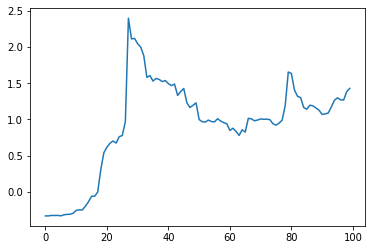

In [29]:
import matplotlib.pyplot as plt

tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [30]:
pwd

'C:\\Users\\jsten\\IBMQ\\Hubbard_symmetries'